# 2016美国大选
[项目地址](https://www.kaggle.com/fivethirtyeight/2016-election-polls)

In [14]:
# 引入必要的库
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# 数据文件地址
filename = './presidential_polls.csv'

### 列名预处理

原始的数据可能并不是我们全部想要的，也许我们只需要其中的几列，所以先不急着把文件都读进来，不如读第一行的列名看看有哪些特征。



In [15]:
# 读取列名，即第一行数据
with open(filename, 'r') as f:
    col_names_str = f.readline()[:-1] # [:-1]表示不读取末尾的换行符'\n'

# 将字符串拆分，并组成列表
col_name_lst = col_names_str.split(',')
print col_name_lst

['cycle', 'branch', 'type', 'matchup', 'forecastdate', 'state', 'startdate', 'enddate', 'pollster', 'grade', 'samplesize', 'population', 'poll_wt', 'rawpoll_clinton', 'rawpoll_trump', 'rawpoll_johnson', 'rawpoll_mcmullin', 'adjpoll_clinton', 'adjpoll_trump', 'adjpoll_johnson', 'adjpoll_mcmullin', 'multiversions', 'url', 'poll_id', 'question_id', 'createddate', 'timestamp']


我们只选取其中一些有用的特征读进来，将这些特征的列名放在use_col_name_lst这个list中。

但是我们用np.loadtxt()方法时，是要根据列的索引去选取列的。所以，我们要找出这些需要的列名所对应的索引。调用.index()方法。

In [16]:
# 使用的列名
use_col_name_ls = ['enddate', 'rawpoll_clinton', 'rawpoll_trump','adjpoll_clinton', 'adjpoll_trump']

# 获取相应列名的索引号
use_col_index_lst = [col_name_lst.index(use_col_name) for use_col_name in use_col_name_ls]
print use_col_index_lst

[7, 13, 14, 17, 18]


### 数据读取

调用np.loadtxt()

读取之后总共有10236行，5列

In [17]:
data_array = np.loadtxt(filename,      # 文件名
                        delimiter=',', # 分隔符
                        skiprows=1,    # 跳过第一行，即跳过列名
                        dtype=str,     # 数据类型
                        usecols=use_col_index_lst) # 指定读取的列索引号

print data_array, data_array.shape

[['10/31/2016' '37.69' '35.07' '42.6414' '40.86509']
 ['10/30/2016' '45' '46' '43.29659' '44.72984']
 ['10/30/2016' '48' '42' '46.29779' '40.72604']
 ..., 
 ['9/22/2016' '46.54' '40.04' '45.9713' '39.97518']
 ['6/21/2016' '43' '43' '45.2939' '46.66175']
 ['8/18/2016' '32.54' '43.61' '31.62721' '44.65947']] (10236L, 5L)


### 数据处理

首先我们明确一下本次分析的最终目的。在上面的数据读取中读入了5列数据，分别是日期和两位总统候选人民意调查的两个指标。
我们的目的是要去统计每个月中这四个指标的民意总和，以便去比较随时间推移两位总统候选人的民意增减情况。

于是首先，要去处理日期数据，提取出这份数据表中的都涉及哪些月份，将这些月份按照升序组成一个列表，以备后用。

1. 首先将所有的日期格式都转变为用/隔开的（因为有些是用-分割的）
2. 将日期字符串转变为日期
3. 将日期格式全部转换为yyyy-mm.  %d表示格式化成整型，%02d表示要格式化成两位数的整型。
4. 将所有日期进行去重，最后得到一个月份列表（之后要去统计每月的数据）

In [18]:
# 处理日期格式数据
enddate_idx = use_col_name_lst.index('enddate')
enddate_lst = data_array[:,enddate_idx].tolist()

# 将日期字符串格式统一，即'yy/dd/mm'
enddate_lst = [enddate.replace('-', '/') for enddate in enddate_lst]

# 将日期字符串转换成日期
date_lst = [datetime.datetime.strptime(enddate, '%m/%d/%Y') for enddate in enddate_lst]

# 构造年份-月份列表
month_lst = ['%d-%02d' %(date_obj.year, date_obj.month) for date_obj in date_lst]

# 将list转换为np.array
month_array = np.array(month_lst)

# 将日期去重后
months = np.unique(month_array)
print months

['2015-11' '2015-12' '2016-01' '2016-02' '2016-03' '2016-04' '2016-05'
 '2016-06' '2016-07' '2016-08' '2016-09' '2016-10']


### 数据分析

有了月份的列表，现在我们要去对4个指标做处理了。

1. 首先，根据索引分别取出这4个指标的整列数据。
2. 然后，对每个月份做遍历，取出每个月份所对应的数据，然后求和加总，可以计算出，每个月份与其所对应的四个投票数的总和。
3. 最后，将这个5类数据再unzip分开成5个list.

In [19]:
# 统计民意投票数
# cliton
# 原始数据 rawpoll
rawpoll_clinton_idx = use_col_name_lst.index('rawpoll_clinton')
rawpoll_clinton_data = data_array[:, rawpoll_clinton_idx]

# 调整后的数据 adhpool
adjpoll_clinton_idx = use_col_name_lst.index('adjpoll_clinton')
adjpoll_clinton_data = data_array[:, adjpoll_clinton_idx]

# trump
# 原始数据 rawpoll
rawpoll_trump_idx = use_col_name_lst.index('rawpoll_trump')
rawpoll_trump_data = data_array[:, rawpoll_trump_idx]

# 调整后的数据 adjpoll
adjpoll_trump_idx = use_col_name_lst.index('adjpoll_trump')
adjpoll_trump_data = data_array[:, adjpoll_trump_idx]

# 结果保存
results = []

def is_convert_float(s):
    """
         判断一个字符串能否转换为float
    """
    try:
        float(s)
    except:
        return False
    
    return True

def get_sum(str_array):
    """
        返回字符串数组中数字的总和
    """
    # 去掉不能转换成数字的数据
    cleaned_data = filter(is_convert_float, str_array)
    
    # 转换数据类型
    float_array = np.array(cleaned_data, np.float)
    
    return np.sum(float_array)
    

for month in months:   
    # clinton
    # 原始数据 rawpoll
    rawpoll_clinton_month_data = rawpoll_clinton_data[month_array == month]  
    # 统计当月的总票数
    rawpoll_clinton_month_sum = get_sum(rawpoll_clinton_month_data)
    
    # 调整数据 adjpoll
    adjpoll_clinton_month_data = adjpoll_clinton_data[month_array == month]  
    # 统计当月的总票数
    adjpoll_clinton_month_sum = get_sum(adjpoll_clinton_month_data)
    
    
    # trump
    # 原始数据 rawpoll
    rawpoll_trump_month_data = rawpoll_trump_data[month_array == month]
    # 统计当月的总票数
    rawpoll_trump_month_sum = get_sum(rawpoll_trump_month_data)
    
    # 调整数据 adjpoll
    adjpoll_trump_month_data = adjpoll_trump_data[month_array == month]
    # 统计当月的总票数
    adjpoll_trump_month_sum = get_sum(adjpoll_trump_month_data)
    
    results.append((month, rawpoll_clinton_month_sum, adjpoll_clinton_month_sum, rawpoll_trump_month_sum, adjpoll_trump_month_sum))
    
print results

months, raw_cliton_sum, adj_cliton_sum, raw_trump_sum, adj_trump_sum = zip(*results)

[('2015-11', 1920.0, 1916.6980600000002, 1948.1999999999998, 1937.3290100000002), ('2015-12', 4816.8000000000002, 4637.2568799999999, 4164.3000000000002, 4088.9218999999994), ('2016-01', 6861.6000768499998, 6585.1670199999999, 6267.0, 6253.24935), ('2016-02', 8271.6002535999996, 7946.228610000001, 7528.2000000000007, 7672.3397999999997), ('2016-03', 11656.202546, 11156.098240000001, 9626.7000000000007, 9991.5935800000007), ('2016-04', 11911.803926799999, 11579.42678, 9396.2999999999993, 9884.1561900000015), ('2016-05', 12155.7247957, 12242.275379999999, 11456.1061505, 12069.761290000002), ('2016-06', 20721.053716300001, 19771.335760000002, 16551.900000000001, 18154.906230000001), ('2016-07', 22007.013854600002, 23233.111679999998, 21426.989999999998, 22757.073270000001), ('2016-08', 63619.396242000003, 67909.282100000011, 59529.0, 66428.29714000001), ('2016-09', 96476.667868899996, 102445.45295000001, 98418.995557400005, 106065.00385000001), ('2016-10', 162766.88891539999, 165319.59354

### 可视化分析结果

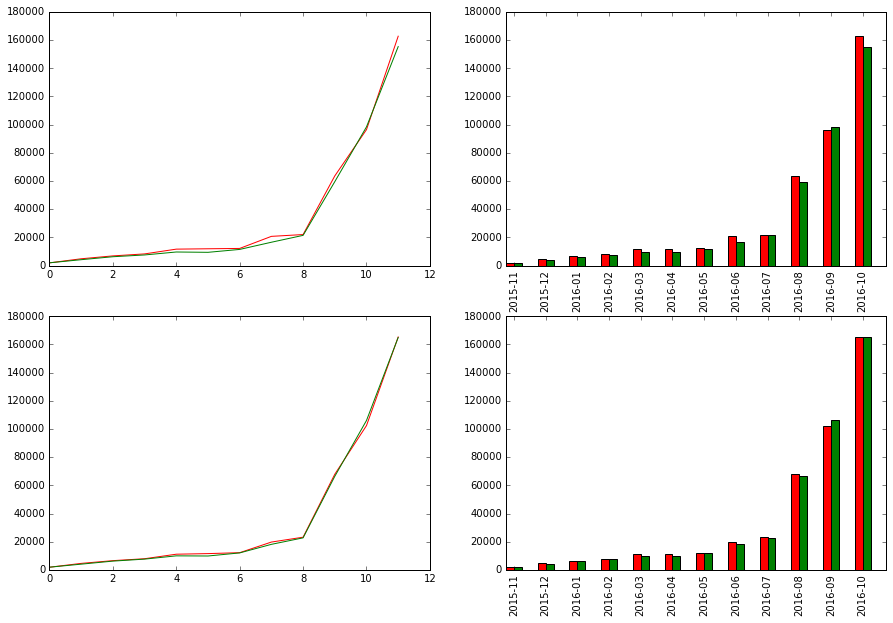

In [23]:
# 创建一个画布，并且分成2*2的4个区域，整个画布大小是15*10cm
fig, subplot_arr = plt.subplots(2,2, figsize=(15,10))

# # 原始数据趋势展示
# 在第一个区域分别画希拉里与川普原始投票的线性图，颜色分别为红色与绿色
subplot_arr[0,0].plot(raw_cliton_sum, color='r')
subplot_arr[0,0].plot(raw_trump_sum, color='g')

# 在第2个区域画出两人原始投票数的直方图
width = 0.25   # 直方的宽度为0.25
x = np.arange(len(months))  # x为直方的个数，是月份的个数
subplot_arr[0,1].bar(x, raw_cliton_sum, width, color='r')
subplot_arr[0,1].bar(x + width, raw_trump_sum, width, color='g')
subplot_arr[0,1].set_xticks(x + width)
subplot_arr[0,1].set_xticklabels(months, rotation='vertical')

# # 调整数据趋势展示
subplot_arr[1,0].plot(adj_cliton_sum, color='r')
subplot_arr[1,0].plot(adj_trump_sum, color='g')

width = 0.25
x = np.arange(len(months))
subplot_arr[1,1].bar(x, adj_cliton_sum, width, color='r')
subplot_arr[1,1].bar(x + width, adj_trump_sum, width, color='g')
subplot_arr[1,1].set_xticks(x + width)
subplot_arr[1,1].set_xticklabels(months, rotation='vertical')

plt.subplots_adjust(wspace=0.2)

plt.show()